In [1]:
from glob import glob

import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score, jaccard_score
import scipy.stats as ss

# Response frequency as the sole predictor of response

In [2]:
def calculate_resp_freq_prediction(resp_filepath, cv_tfs_filepath):
    lfc_cutoff = 0.5
    p_cutoff = 0.05

    cv_tfs = pd.read_csv(cv_tfs_filepath)
    resp_df = pd.read_csv(resp_filepath)
    
    # Filter for TFs in cross-validation and binarize response
    resp_df = resp_df[resp_df['tf_ensg'].isin(cv_tfs['tf'])]
    resp_df['isResp'] = 0
    resp_df.loc[(np.abs(resp_df['log2FoldChange']) > lfc_cutoff) & (resp_df['padj'] < p_cutoff), 'isResp'] = 1

    auc_df = pd.DataFrame()

    for cv in range(10):
        tr_tfs = cv_tfs.loc[cv_tfs['cv'] != cv, 'tf']
        te_tfs = cv_tfs.loc[cv_tfs['cv'] == cv, 'tf']
        
        # Caluclate response frequency across training TFs as prediction
        pred_df = resp_df[resp_df['tf_ensg'].isin(tr_tfs)].groupby(['gene_ensg'])[['isResp']].mean().reset_index()
        pred_df = pred_df.sort_values('gene_ensg')

        for te_tf in te_tfs:
            # Calculate AUC on testing TFs
            true_df = resp_df.loc[(resp_df['tf_ensg'] == te_tf), ['gene_ensg', 'isResp']]
            true_df = true_df.sort_values('gene_ensg')
            auc = average_precision_score(true_df['isResp'], pred_df['isResp'])

            auc_df = auc_df.append(pd.Series({'tf': te_tf, 'auprc': auc}), ignore_index=True)

    return auc_df.sort_values('auprc', ascending=False)

In [3]:
k562_df = calculate_resp_freq_prediction(
    '../RESOURCES/Human_K562_TFPert/K562_pertResp_DESeq2_long.csv',
    '../OUTPUT/human_k562/all_feats/stats.csv.gz'
)

h1_df = calculate_resp_freq_prediction(
    '../RESOURCES/Human_H1_TFPert/TGI_GRCh38_pertResp_DESeq_long.csv',
    '../OUTPUT/human_h1/all_feats/stats.csv.gz'
)

hek_df = calculate_resp_freq_prediction(
    '../RESOURCES/Human_HEK293_TFPert/GSE76495_OE_log2FC_long.csv',
    '../OUTPUT/human_hek293/all_feats/stats.csv.gz'
)

In [4]:
k562_stats = pd.concat([k562_df.describe(), pd.DataFrame({'auprc': [np.median(k562_df['auprc'])]}, index=['median'])]).rename(columns={'auprc': 'K562'})
h1_stats = pd.concat([h1_df.describe(), pd.DataFrame({'auprc': [np.median(h1_df['auprc'])]}, index=['median'])]).rename(columns={'auprc': 'H1'})
hek_stats = pd.concat([hek_df.describe(), pd.DataFrame({'auprc': [np.median(hek_df['auprc'])]}, index=['median'])]).rename(columns={'auprc': 'HEK293'})

stats = pd.concat([k562_stats, h1_stats, hek_stats], axis=1)

display(stats)

,K562,H1,HEK293
count,42.000000,23.000000,80.000000
mean,0.435368,0.162610,0.323638
std,0.281200,0.150284,0.097457
min,0.015158,0.000284,0.146989
25%,0.139614,0.046640,0.257607
50%,0.427388,0.106467,0.303668
75%,0.668673,0.279388,0.387650
max,0.887676,0.572410,0.601451
median,0.427388,0.106467,0.303668


In [5]:
k562_df.to_csv('g3_revision/response_frequency_prediction.k562.csv', index=False)
h1_df.to_csv('g3_revision/response_frequency_prediction.h1.csv', index=False)
hek_df.to_csv('g3_revision/response_frequency_prediction.hek293.csv', index=False)

stats.to_csv('g3_revision/response_frequency_prediction.stats.csv', index=False)

# Jaccard similarity of responsive gene set for each TF pair

In [9]:
def calculate_resp_gene_jaccard(resp_filepath, cv_tfs_filepath):
    lfc_cutoff = 0.5
    p_cutoff = 0.05

    tfs = pd.read_csv(cv_tfs_filepath)['tf'].to_list()
    resp_df = pd.read_csv(resp_filepath)
    
    # Filter for TFs in cross-validation and binarize response
    resp_df = resp_df[resp_df['tf_ensg'].isin(tfs)]
    resp_df['isResp'] = 0
    resp_df.loc[(np.abs(resp_df['log2FoldChange']) > lfc_cutoff) & (resp_df['padj'] < p_cutoff), 'isResp'] = 1
    
    # Calculate Jaccard similarity of each TF pair
    jacc_df = pd.DataFrame()
    n = len(tfs)
    
    for i in range(n - 1):
        for j in range(i + 1, n):
            tf1, tf2 = tfs[i], tfs[j]
            tf1_resp = resp_df.loc[resp_df['tf_ensg'] == tf1, ['gene_ensg', 'isResp']].sort_values('gene_ensg')
            tf2_resp = resp_df.loc[resp_df['tf_ensg'] == tf2, ['gene_ensg', 'isResp']].sort_values('gene_ensg')
            score = jaccard_score(tf1_resp['isResp'], tf2_resp['isResp'])
            
            jacc_df = jacc_df.append(pd.Series({'tfPair': tf1 + '-' + tf2, 'jaccScore': score}), ignore_index=True)
    
    return jacc_df

In [13]:
k562_df = calculate_resp_gene_jaccard(
    '../RESOURCES/Human_K562_TFPert/K562_pertResp_DESeq2_long.csv',
    '../OUTPUT/human_k562/all_feats/stats.csv.gz'
)

h1_df = calculate_resp_gene_jaccard(
    '../RESOURCES/Human_H1_TFPert/TGI_GRCh38_pertResp_DESeq_long.csv',
    '../OUTPUT/human_h1/all_feats/stats.csv.gz'
)

hek_df = calculate_resp_gene_jaccard(
    '../RESOURCES/Human_HEK293_TFPert/GSE76495_OE_log2FC_long.csv',
    '../OUTPUT/human_hek293/all_feats/stats.csv.gz'
)

In [14]:
k562_stats = pd.concat([k562_df.describe(), pd.DataFrame({'jaccScore': [np.median(k562_df['jaccScore'])]}, index=['median'])]).rename(columns={'jaccScore': 'K562'})
h1_stats = pd.concat([h1_df.describe(), pd.DataFrame({'jaccScore': [np.median(h1_df['jaccScore'])]}, index=['median'])]).rename(columns={'jaccScore': 'H1'})
hek_stats = pd.concat([hek_df.describe(), pd.DataFrame({'jaccScore': [np.median(hek_df['jaccScore'])]}, index=['median'])]).rename(columns={'jaccScore': 'HEK293'})

stats = pd.concat([k562_stats, h1_stats, hek_stats], axis=1)

display(stats)

,K562,H1,HEK293
count,861.000000,253.000000,3160.000000
mean,0.121900,0.043795,0.119987
std,0.145066,0.052308,0.047740
min,0.000000,0.000000,0.014586
25%,0.024076,0.010139,0.089890
50%,0.072350,0.024595,0.113495
75%,0.144661,0.053430,0.141489
max,0.710059,0.309119,0.601491
median,0.072350,0.024595,0.113495


In [15]:
k562_df.to_csv('g3_revision/jaccard_resp_set.k562.csv', index=False)
h1_df.to_csv('g3_revision/jaccard_resp_set.h1.csv', index=False)
hek_df.to_csv('g3_revision/jaccard_resp_set.hek293.csv', index=False)

stats.to_csv('g3_revision/jaccard_resp_set.stats.csv', index=False)

# Correlation of response frequency for each cell line pair

In [16]:
def calculate_resp_freq(resp_filepath, cv_tfs_filepath):
    lfc_cutoff = 0.5
    p_cutoff = 0.05

    tfs = pd.read_csv(cv_tfs_filepath)['tf'].to_list()
    resp_df = pd.read_csv(resp_filepath)
    
    # Filter for TFs in cross-validation and binarize response
    resp_df = resp_df[resp_df['tf_ensg'].isin(tfs)]
    resp_df['isResp'] = 0
    resp_df.loc[(np.abs(resp_df['log2FoldChange']) > lfc_cutoff) & (resp_df['padj'] < p_cutoff), 'isResp'] = 1
    
    freq_df = resp_df.groupby(['gene_ensg'])[['isResp']].mean().reset_index()
    return freq_df

In [22]:
k562_freq = calculate_resp_freq(
    '../RESOURCES/Human_K562_TFPert/K562_pertResp_DESeq2_long.csv',
    '../OUTPUT/human_k562/all_feats/stats.csv.gz'
)

h1_freq = calculate_resp_freq(
    '../RESOURCES/Human_H1_TFPert/TGI_GRCh38_pertResp_DESeq_long.csv',
    '../OUTPUT/human_h1/all_feats/stats.csv.gz'
)

hek_freq = calculate_resp_freq(
    '../RESOURCES/Human_HEK293_TFPert/GSE76495_OE_log2FC_long.csv',
    '../OUTPUT/human_hek293/all_feats/stats.csv.gz'
)

common_genes = set(k562_freq['gene_ensg'].tolist()) & \
                set(h1_freq['gene_ensg'].tolist()) & \
                set(hek_freq['gene_ensg'].tolist())

k562_freq = k562_freq[k562_freq['gene_ensg'].isin(common_genes)].sort_values('gene_ensg')
h1_freq = h1_freq[h1_freq['gene_ensg'].isin(common_genes)].sort_values('gene_ensg')
hek_freq = hek_freq[hek_freq['gene_ensg'].isin(common_genes)].sort_values('gene_ensg')

pearson_stats = pd.DataFrame()

r, p = ss.pearsonr(k562_freq['isResp'], h1_freq['isResp'])
pearson_stats = pearson_stats.append(pd.Series({'tfPair': 'K562-H1', 'pearsonR': r, 'pearsonPval': p}), ignore_index=True)
r, p = ss.pearsonr(k562_freq['isResp'], hek_freq['isResp'])
pearson_stats = pearson_stats.append(pd.Series({'tfPair': 'K562-HEK293', 'pearsonR': r, 'pearsonPval': p}), ignore_index=True)
r, p = ss.pearsonr(h1_freq['isResp'], hek_freq['isResp'])
pearson_stats = pearson_stats.append(pd.Series({'tfPair': 'H1-HEK293', 'pearsonR': r, 'pearsonPval': p}), ignore_index=True)

display(pearson_stats)

,pearsonPval,pearsonR,tfPair
0,6.775135e-119,0.164214,K562-H1
1,5.072378e-42,0.096643,K562-HEK293
2,3.745144e-243,0.234187,H1-HEK293


In [25]:
pearson_stats[['tfPair', 'pearsonR', 'pearsonPval']].to_csv(
    'g3_revision/response_frequency_correlation.csv', index=False
)

# DE Prior (Crow, 2019) as the sole predictor of response

In [2]:
def load_de_prior(de_prior_filepath, gene_map_filepath):
    de_prior = pd.read_csv(de_prior_filepath, sep='\t')
    gene_map = pd.read_csv(gene_map_filepath, sep='\t')
    gene_map = gene_map.rename(columns={'ensembl_gene_id': 'gene_ensg', 'external_gene_name': 'Gene_Name'})
    
    de_prior = de_prior.merge(gene_map, on='Gene_Name', how='inner')
    
    return de_prior[['gene_ensg', 'DE_Prior_Rank']]


def calculate_de_prior_prediction(de_prior_df, resp_filepath, cv_tfs_filepath):
    lfc_cutoff = 0.5
    p_cutoff = 0.05

    cv_tfs = pd.read_csv(cv_tfs_filepath)
    resp_df = pd.read_csv(resp_filepath)
    
    # Filter for TFs in cross-validation and binarize response
    resp_df = resp_df[resp_df['tf_ensg'].isin(cv_tfs['tf'])]
    resp_df['isResp'] = 0
    resp_df.loc[(np.abs(resp_df['log2FoldChange']) > lfc_cutoff) & (resp_df['padj'] < p_cutoff), 'isResp'] = 1

    auc_df = pd.DataFrame()

    for tf in cv_tfs['tf'].tolist():
        # Calculate AUC on testing TFs
        comb_df = resp_df.loc[(resp_df['tf_ensg'] == tf), ['gene_ensg', 'isResp']]
        comb_df = comb_df.merge(de_prior_df, on='gene_ensg', how='inner')
        comb_df = comb_df.sort_values('gene_ensg')
        auc = average_precision_score(comb_df['isResp'], comb_df['DE_Prior_Rank'])

        auc_df = auc_df.append(pd.Series({'tf': tf, 'auprc': auc}), ignore_index=True)

    return auc_df.sort_values('auprc', ascending=False)

In [3]:
de_prior_df = load_de_prior(
    '../../human_data/DE_Prior_Crow_2019/DEprior/DE_Prior.txt',
    '../../human_data/hg38_genome/genes.ENSG.tbl'
)

print(de_prior_df.shape)
display(de_prior_df.head())

(18474, 2)


,gene_ensg,DE_Prior_Rank
0,ENSG00000229807,1.000000
1,ENSG00000067048,0.999948
2,ENSG00000198692,0.999870
3,ENSG00000012817,0.999870
4,ENSG00000114374,0.999791


In [4]:
k562_df = calculate_de_prior_prediction(
    de_prior_df,
    '../RESOURCES/Human_K562_TFPert/K562_pertResp_DESeq2_long.csv',
    '../OUTPUT/human_k562/all_feats/stats.csv.gz'
)

h1_df = calculate_de_prior_prediction(
    de_prior_df,
    '../RESOURCES/Human_H1_TFPert/TGI_GRCh38_pertResp_DESeq_long.csv',
    '../OUTPUT/human_h1/all_feats/stats.csv.gz'
)

hek_df = calculate_de_prior_prediction(
    de_prior_df,
    '../RESOURCES/Human_HEK293_TFPert/GSE76495_OE_log2FC_long.csv',
    '../OUTPUT/human_hek293/all_feats/stats.csv.gz'
)

In [5]:
k562_stats = pd.concat([k562_df.describe(), pd.DataFrame({'auprc': [np.median(k562_df['auprc'])]}, index=['median'])]).rename(columns={'auprc': 'K562'})
h1_stats = pd.concat([h1_df.describe(), pd.DataFrame({'auprc': [np.median(h1_df['auprc'])]}, index=['median'])]).rename(columns={'auprc': 'H1'})
hek_stats = pd.concat([hek_df.describe(), pd.DataFrame({'auprc': [np.median(hek_df['auprc'])]}, index=['median'])]).rename(columns={'auprc': 'HEK293'})

stats = pd.concat([k562_stats, h1_stats, hek_stats], axis=1)

display(stats)

,K562,H1,HEK293
count,42.000000,23.000000,80.000000
mean,0.091143,0.105769,0.118352
std,0.078805,0.120176,0.059632
min,0.001507,0.000212,0.017180
25%,0.023039,0.020895,0.078448
50%,0.057645,0.051593,0.103492
75%,0.157298,0.177593,0.157015
max,0.264420,0.465133,0.287455
median,0.057645,0.051593,0.103492


In [6]:
k562_df.to_csv('g3_revision/de_prior_prediction.k562.csv', index=False)
h1_df.to_csv('g3_revision/de_prior_prediction.h1.csv', index=False)
hek_df.to_csv('g3_revision/de_prior_prediction.hek293.csv', index=False)

stats.to_csv('g3_revision/de_prior_prediction.stats.csv', index=False)

### Compare DE Prior predictive power against chance

In [15]:
from plotnine import *

def resp_ratio(x):
    return sum(x == 1) / len(x)

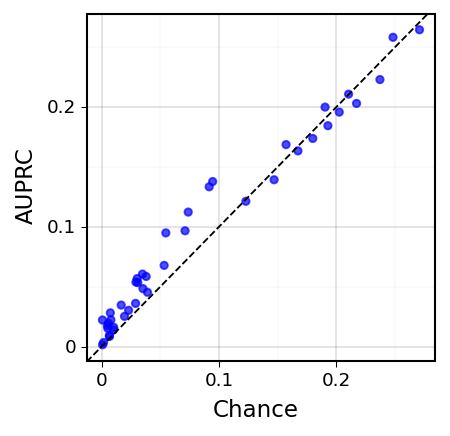

<ggplot: (1426865630626)>

In [19]:
organism = 'human_k562'
output_dir = '../OUTPUT/human_k562/all_feats/'

pred_df = pd.read_csv(output_dir + 'preds.csv.gz')
rr_df = pred_df.groupby('tf')['label'].agg(resp_ratio).reset_index()

plot_df = k562_df.merge(rr_df, on='tf').dropna()

ax = (
    ggplot(plot_df, aes(x='label', y='auprc'))
    + geom_point(color='blue', alpha=.7)
    + geom_abline(slope=1, intercept=0, linetype='dashed')
    + labs(x='Chance', y='AUPRC')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

display(ax)

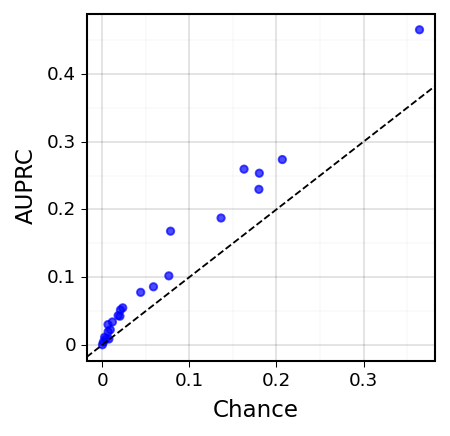

<ggplot: (1426872877295)>

In [20]:
organism = 'human_h1'
output_dir = '../OUTPUT/human_h1/all_feats/'

pred_df = pd.read_csv(output_dir + 'preds.csv.gz')
rr_df = pred_df.groupby('tf')['label'].agg(resp_ratio).reset_index()

plot_df = h1_df.merge(rr_df, on='tf').dropna()

ax = (
    ggplot(plot_df, aes(x='label', y='auprc'))
    + geom_point(color='blue', alpha=.7)
    + geom_abline(slope=1, intercept=0, linetype='dashed')
    + labs(x='Chance', y='AUPRC')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

display(ax)

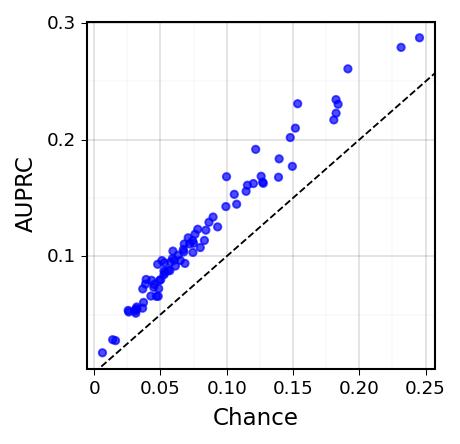

<ggplot: (-9223370609994344760)>

In [22]:
organism = 'human_hek293'
output_dir = '../OUTPUT/human_hek293/all_feats/'

pred_df = pd.read_csv(output_dir + 'preds.csv.gz')
rr_df = pred_df.groupby('tf')['label'].agg(resp_ratio).reset_index()

plot_df = hek_df.merge(rr_df, on='tf').dropna()

ax = (
    ggplot(plot_df, aes(x='label', y='auprc'))
    + geom_point(color='blue', alpha=.7)
    + geom_abline(slope=1, intercept=0, linetype='dashed')
    + labs(x='Chance', y='AUPRC')
    + theme_linedraw()
    + theme(figure_size=(3, 3), dpi=150)
)

display(ax)